<a href="https://colab.research.google.com/github/varun-bharadwaj/cs182-final-proj/blob/main/CS182_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Imports:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import random

1. Training Data Generation

In [2]:
# Assumptions / constants (inputs)
NUM_VERTICES = 3
WEIGHT_MEAN = 9.0
WEIGHT_STD = 5.0
SOURCE_NODE_INDEX = 0 # Can also make random

# Output: Adjacency matrix for the graph, and one hot encoded vectors for the source and sink node

In [98]:
### EDGE WEIGHT GENERATORS ###

def gaussian_edge_weight(edge_weight_mean = WEIGHT_MEAN,
                         edge_weight_stddev = WEIGHT_STD,
                         no_edge_prob = 0.0,
                         whole_num_only = True):
  """
  Generates a single edge weight that follows a normal distribution with the given parameters but negative weights are clipped to 0.
  There is a no_edge_prob that the weight will instead get set to np.inf (to simulate that edge not existing in the graph)
  """
  if random.random() < no_edge_prob:
    return 100
  else:
    weight = max(0, np.random.normal(edge_weight_mean, edge_weight_stddev))
    if whole_num_only: return np.floor(weight)
    else: return weight

def uniform_edge_weight(edge_weight_min = 0.0,
                        edge_weight_max = 10.0,
                        no_edge_prob = 0.0,
                        whole_num_only = True):
  """
  Generates a single edge weight that follows a uniform distribution with the given parameters.
  There is a no_edge_prob that the weight will instead get set to np.inf (to simulate that edge not existing in the graph)
  """
  if random.random() < no_edge_prob:
    return 10_000
  else:
    weight = np.random.uniform(edge_weight_min, edge_weight_max)
    if whole_num_only: return np.floor(weight)
    else: return weight

### END EDGE WEIGHT GENERATORS ###

In [99]:
def generate_shortest_path_problem(num_vertices,
                                   source_index = SOURCE_NODE_INDEX,
                                   edge_weight_generator = gaussian_edge_weight,
                                   undirected = True):
  """
  Generates a single shortest path problem with the specified number of vertices.
  Edge weights are generated by edge_weight_generator (passed in function).

  Output format:
    - A, an (n+1) x n numpy matrix.
    - The first row is a one hot encoded vector of the source node. (A[0][i] == 1 if i is the source node else 0)
    - Each subsequent row is a row of the adjacency matrix.
    - So A[i+1][j] represents the cost of the edge from i -> j. Therefore it is a constant that A[i+1][i] = 0 for all i.
    - If undirected is True, then A[i+1][j] = A[j+1][i] for all i, j. Otherwise, they can be different
  """

  # Generate random graph:
  A = np.zeros((num_vertices + 1, num_vertices))
  A[0][source_index] = 1
  if undirected:
    for i in range(num_vertices):
      for j in range(i+1, num_vertices):
          A[i+1][j] = edge_weight_generator()
          A[j+1][i] = A[i+1][j]
  else:
    for i in range(num_vertices):
      for j in range(num_vertices):
        if i != j:
          A[i+1][j] = edge_weight_generator()

  return A


def solve_shortest_path_problem(A):
  """
  Solves a shortest path problem that is in the format outputted by generate_shortest_path_problem.

  Output format:
    - S, a numpy array of length n. Each element is the length of the shortest path from the source node to that vertex.
    - So S[i] = len of shortest path from source_index -> i. Therefore it is a constant that S[source_index] = 0.
  """

  n = A.shape[1]
  source_index = np.nonzero(A[0])[0][0]

  # Solve graph with bellman ford (so we can add negative edges if desired):
  S = np.full(n, np.inf)
  S[source_index] = 0
  for _ in range(n):
    for i in range(n):
      for j in range(n):
        if S[i] + A[i+1][j] < S[j]:
          S[j] = S[i] + A[i+1][j]

  # Return
  return S


In [100]:
def generate_interesting_problem(num_vertices,
                                 source_index = SOURCE_NODE_INDEX,
                                 undirected = True):

  """
  Generates a single shortest path problem with the specified number of vertices.
  Edge weights are specifically generated so there is at least one shortest path that is "long" (>2 edges) in expectation
  """

  A = np.zeros((num_vertices + 1, num_vertices))
  A[0][source_index] = 1

  # Assign a random sequence number to each vertex (with source_index -> 0)
  # Then we will assign "on path" (seq # -> seq #+1) edges to a low weight and
  # "off path" edges to a high weight with some random variance added in
  seq_num = [i for i in range(num_vertices)]
  random.shuffle(seq_num)
  idx_0 = seq_num.index(0)
  seq_num[source_index], seq_num[idx_0] = 0, seq_num[source_index]

  if undirected:
    for i in range(num_vertices):
      for j in range(i+1, num_vertices):
          diff = abs(seq_num[i] - seq_num[j])
          if diff == 1: # on path edge
            A[i+1][j] = random.randint(1, 3)
            A[j+1][i] = A[i+1][j]
          else: # off path edge
            A[i+1][j] = random.randint(5 + diff, 8 + diff) # longer "skips" have higher val in expectation
            A[j+1][i] = A[i+1][j]
  else:
    for i in range(num_vertices):
      for j in range(num_vertices):
        if i != j:
          diff = abs(seq_num[i] - seq_num[j])
          if diff == 1: # on path edge
            A[i+1][j] = random.randint(1, 3)
          else: # off path edge
            A[i+1][j] = random.randint(5 + diff, 8 + diff) # longer "skips" have higher val in expectation

  return A




In [101]:
# TESTING CODE
A = generate_shortest_path_problem(NUM_VERTICES, edge_weight_generator=gaussian_edge_weight, source_index=random.randint(0, NUM_VERTICES - 1))
print(A)
S = solve_shortest_path_problem(A)
print(S)

[[ 0.  0.  1.]
 [ 0.  9.  4.]
 [ 9.  0. 12.]
 [ 4. 12.  0.]]
[ 4. 12.  0.]


In [102]:
def generate_batch(batch_size,
                   num_vertices = NUM_VERTICES,
                   source_index = SOURCE_NODE_INDEX,
                   edge_weight_generator = gaussian_edge_weight,
                   undirected = True):
  """
  Generates a batch of shortest path problems. Outputs two np tensors, A_batch and S_batch

  All problems in the batch have to have the same "format" (num_vertices, source_index, edge_weight_generator, undirected)

  A_batch: np array of shape (batch_size, num_vertices + 1, num_vertices)
  S_batch: np array of shape (batch_size, num_vertices)
  """

  A_list = []
  S_list = []
  while len(A_list) < batch_size:
    A = generate_shortest_path_problem(num_vertices, source_index, edge_weight_generator, undirected)
    S = solve_shortest_path_problem(A)
    if np.sum(S) < 100:
      A_list.append(A)
      S_list.append(S)

  A_batch = np.stack(A_list, axis=0)
  S_batch = np.stack(S_list, axis=0)

  return A_batch, S_batch



def generate_interesting_batch(batch_size,
                   num_vertices = NUM_VERTICES,
                   source_index = SOURCE_NODE_INDEX,
                   edge_weight_generator = gaussian_edge_weight,
                   undirected = True):
  """
  Generates a batch of shortest path problems. Outputs two np tensors, A_batch and S_batch

  All problems in the batch have to have the same "format" (num_vertices, source_index, edge_weight_generator, undirected)

  A_batch: np array of shape (batch_size, num_vertices + 1, num_vertices)
  S_batch: np array of shape (batch_size, num_vertices)
  """

  A_list = []
  S_list = []
  while len(A_list) < batch_size:
    A = generate_interesting_problem(num_vertices, source_index, undirected)
    S = solve_shortest_path_problem(A)
    if np.sum(S) < 100:
      A_list.append(A)
      S_list.append(S)


  A_batch = np.stack(A_list, axis=0)
  S_batch = np.stack(S_list, axis=0)

  return A_batch, S_batch

2. Transformer Architecture Setup

In [103]:
# 2. Transformer Architecture Setup][-olk,m ]
# Input: Graph as an adjacency matrix inputted as vectors with one hot encoding vectors added for the source and sink node
# --> Tokens are the vectors in adjacency matrix, one for each vertex
# Output: Option 1: Real valued output for length of shortest path; Option 2: reconstructed path
#   Option 3: Could also output a vector which for V[i] = length of shortest path to vertex i (single source shortest paths)
#   in this case we don't need one hot encoded source/sink vectors as input
# Loss: Opt1: Squared error; Opt2: Frobenius norm

In [104]:

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.0):
        super(TransformerModel, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)  # Project input to model dimension
        self.pos_encoder = PositionalEncoding(model_dim, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=2*model_dim,
            nhead=num_heads,
            dim_feedforward=8*model_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(2*model_dim, output_dim)

    def forward(self, src):
        # src shape: (batch_size, sequence_length, input_dim)
        src = self.input_proj(src)
        src = self.pos_encoder(src)
        x = self.transformer_encoder(src)
        output = self.output_proj(x)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, dropout=0.0, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # shape (1, max_len, model_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, model_dim)
        # x = x + self.pe[:, :x.size(1)]
        B, S, D = x.size()
        x = torch.cat((x, self.pe[:, :S, :].expand(B, -1, -1)), dim=-1)
        return self.dropout(x)

3. Transformer Training

In [106]:

# 3. Training Time Transformer
# Input: ___ number of randomly generated examples from the training data generation and the transformer model
# Output: None

batch_size = 32
num_vertices = 6
input_dim = num_vertices
output_dim = num_vertices

model_dim = 10
num_heads = 4
num_layers = 4

num_batches = 10_000

model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss(beta=0.1)
percentage_non_interesting = 0.5
losses = [] # loss per batch
model.train()
for i in tqdm(range(num_batches)):
  if i > num_batches * percentage_non_interesting:
    x_batch, y_batch = generate_interesting_batch(batch_size, source_index=random.randint(0, num_vertices - 1) , num_vertices=num_vertices, edge_weight_generator=gaussian_edge_weight)
  else:
    x_batch, y_batch = generate_batch(batch_size, source_index=random.randint(0, num_vertices - 1), num_vertices=num_vertices, edge_weight_generator=gaussian_edge_weight)
  x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)

  optimizer.zero_grad()
  output = model(x_batch)
  pred_distances = output[:, -1, :]
  loss = loss_fn(pred_distances, y_batch)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())
  if i % 1000 == 0:
    print(f"Batch {i+1}, Loss: {loss.item()}")

    torch.save({
        'epoch': i // 1000,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'iter_{i}.pth')


  0%|          | 11/10000 [00:00<03:14, 51.38it/s]

Batch 1, Loss: 5.433261871337891


 10%|█         | 1007/10000 [00:17<02:48, 53.40it/s]

Batch 1001, Loss: 2.183500289916992


 20%|██        | 2009/10000 [00:35<02:23, 55.61it/s]

Batch 2001, Loss: 1.225136160850525


 30%|███       | 3011/10000 [00:53<02:06, 55.32it/s]

Batch 3001, Loss: 0.7942861318588257


 40%|████      | 4007/10000 [01:10<01:47, 55.56it/s]

Batch 4001, Loss: 0.7998042106628418


 50%|█████     | 5009/10000 [01:28<01:29, 56.01it/s]

Batch 5001, Loss: 0.8424500823020935


 60%|██████    | 6008/10000 [01:45<01:07, 58.88it/s]

Batch 6001, Loss: 0.5303750038146973


 70%|███████   | 7011/10000 [02:01<00:51, 58.18it/s]

Batch 7001, Loss: 0.4874212145805359


 80%|████████  | 8012/10000 [02:18<00:33, 58.93it/s]

Batch 8001, Loss: 0.5117778778076172


 90%|█████████ | 9010/10000 [02:35<00:16, 59.00it/s]

Batch 9001, Loss: 0.46696484088897705


100%|██████████| 10000/10000 [02:52<00:00, 58.08it/s]


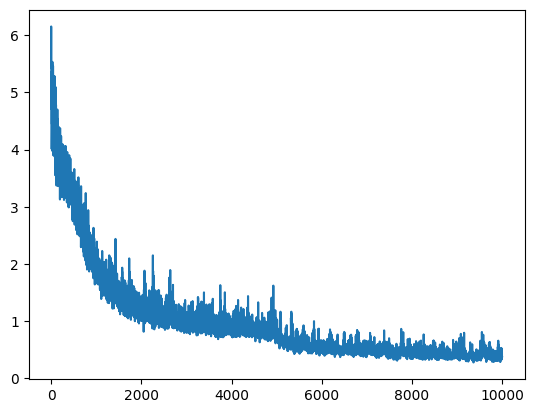

In [107]:
plt.plot(range(len(losses)), losses)

4. Transformer Testing

In [111]:
# 4. Test Time Transformer
# Input: Newly generated random examples, can experiment with different number of vertices to check ICL capability
# Output: Accuracy measurements (figure out what these should be)

model.eval()
x_batch, y_batch = generate_batch(1, source_index = random.randint(0, num_vertices-1), num_vertices=num_vertices, edge_weight_generator=gaussian_edge_weight)

x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
print(x_batch)
torch.set_printoptions(sci_mode=False, precision=1)
output = model(x_batch)
pred_distances = output[:, -1, :]

print(pred_distances)
print(y_batch)

tensor([[[ 0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0., 13., 13.,  0.,  9.],
         [ 0.,  0., 14., 12.,  7.,  5.],
         [13., 14.,  0.,  5., 21.,  6.],
         [13., 12.,  5.,  0.,  4.,  3.],
         [ 0.,  7., 21.,  4.,  0., 13.],
         [ 9.,  5.,  6.,  3., 13.,  0.]]], device='cuda:0')
tensor([[0.7, 0.3, 5.6, 4.7, 1.5, 4.1]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0., 0., 9., 4., 0., 5.]], device='cuda:0')


In [ ]:
model.eval()
x_batch, y_batch = generate_interesting_batch(32, source_index = random.randint(0, num_vertices-1), num_vertices=num_vertices, edge_weight_generator=gaussian_edge_weight)

x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
torch.set_printoptions(sci_mode=False, precision=1)
output = model(x_batch)
pred_distances = output[:, -1, :]

print(pred_distances)
print(y_batch)

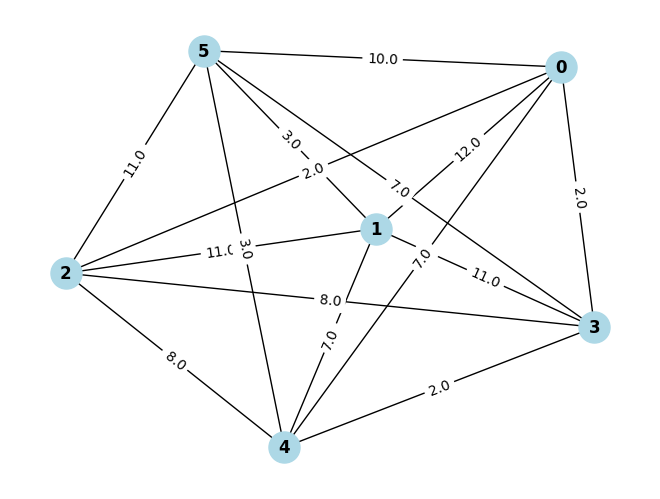

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
# Example weight matrix (symmetric for undirected graph, 0 means no edge)
weight_matrix = x_batch.squeeze(0)[1:, :].detach().cpu().numpy()
# Create a graph
G = nx.Graph()
# Add edges with weights
n = len(weight_matrix)
for i in range(n):
    for j in range(i+1, n):
        weight = weight_matrix[i][j]
        G.add_edge(i, j, weight=weight)
# Position the nodes using a layout
pos = nx.spring_layout(G)
# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')
# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

5. (Optional) Project Extensions

In [ ]:
# 5. Extensions of Project (Optional)
# Choices:
# Add higher number of vertices to make the graph more complex
# Add the option 2 for output of model - output entire path instead of just length
# Make the edge weights non-negative or even negative (adjust training data to use bellman-ford)
# Add A* search capability with admissible heuristics into the training data